# Supervised sentiment: Dense feature representations and neural networks

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2018 term"

## Contents

0. [Overview](#Overview)
0. [Set-up](#Set-up)
0. [Distributed representations as features](#Distributed-representations-as-features)
  0. [GloVe inputs](#GloVe-inputs)
  0. [IMDB representations](#IMDB-representations)
  0. [Remarks on this approach](#Remarks-on-this-approach)
0. [RNN classifiers](#RNN-classifiers)
  0. [RNN dataset preparation](#RNN-dataset-preparation)
  0. [Vocabulary for the embedding](#Vocabulary-for-the-embedding)
  0. [Pure NumPy RNN implementation](#Pure-NumPy-RNN-implementation)
  0. [TensorFlow implementation](#TensorFlow-implementation)
0. [Tree-structured neural networks](#Tree-structured-neural-networks)
  0. [TreeNN dataset preparation](#TreeNN-dataset-preparation)
  0. [Pure NumPy TreeNN implementation](#Pure-NumPy-TreeNN-implementation)
0. [Exploratory exercises](#Exploratory-exercises)

## Overview

This notebook defines and explores __recurrent neural network (RNN) classifiers__ and __tree-structured neural network (TreeNN) classifiers__ for the Stanford Sentiment Treebank. 

These approaches make their predictions based on comprehensive representations of the examples: 

* For the RNN, each word is modeled, as are its sequential relationships to the other words.
* For the TreeNN, the entire parsed structure of the sentence is modeled.

Both models contrast with the ones explored in [the previous notebook](sst_02_hand_built_features.ipynb), which make predictions based on more partial, potentially idiosyncratic information extracted from the examples.

## Set-up

See [the first notebook in this unit](sst_01_overview.ipynb#Set-up) for set-up instructions.

In [2]:
from collections import Counter
import numpy as np
import os
import pandas as pd
import random
from rnn_classifier import RNNClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import tensorflow as tf
from tf_rnn_classifier import TfRNNClassifier
from tree_nn import TreeNN
import sst
import vsm
import utils

/Applications/anaconda/envs/nlu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
vsmdata_home = 'vsmdata'

glove_home = os.path.join(vsmdata_home, 'glove.6B')

## Distributed representations as features

As a first step in the direction of neural networks for sentiment, we can connect with our previous unit on distributed representations. Arguably, more than any specific model architecture, this is the major innovation of deep learning: __rather than designing feature functions by hand, we use dense, distributed representations, often derived from unsupervised models__.

Our model will just be `LogisticRegression`, and we'll continue with the experiment framework from the previous notebook. Here is `fit_maxent_classifier` again:

In [4]:
def fit_maxent_classifier(X, y):   
    mod = LogisticRegression(fit_intercept=True)
    mod.fit(X, y)
    return mod

### GloVe inputs

To illustrate this process, we'll use the general purpose GloVe representations released by the GloVe team, at 50d:

In [5]:
glove_lookup = utils.glove2dict(
    os.path.join(glove_home, 'glove.6B.50d.txt'))

In [6]:
def vsm_leaves_phi(tree, lookup, np_func=np.sum):
    """Represent `tree` as a combination of the vector of its words.
    
    Parameters
    ----------
    tree : nltk.Tree   
    lookup : dict
        From words to vectors.
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. The requirement is that 
        the function take `axis=0` as one of its arguments (to ensure
        columnwise combination) and that it return a vector of a 
        fixed length, no matter what the size of the tree is.
    
    Returns
    -------
    np.array, dimension `X.shape[1]`
            
    """      
    allvecs = np.array([lookup[w] for w in tree.leaves() if w in lookup])    
    if len(allvecs) == 0:
        dim = len(next(iter(lookup.values())))
        feats = np.zeros(dim)
    else:       
        feats = np_func(allvecs, axis=0)      
    return feats

In [7]:
def glove_leaves_phi(tree, np_func=np.sum):
    return vsm_leaves_phi(tree, glove_lookup, np_func=np_func)

In [8]:
_ = sst.experiment(
    glove_leaves_phi,
    fit_maxent_classifier,
    class_func=sst.binary_class_func,
    vectorize=False)  # Tell `experiment` that we already have our feature vectors.

Accuracy: 0.732
             precision    recall  f1-score   support

   negative      0.715     0.718     0.717       981
   positive      0.746     0.744     0.745      1095

avg / total      0.732     0.732     0.732      2076



### IMDB representations

Our IMDB VSMs seems pretty well-attuned to the Stanford Sentiment Treebank, so we might think that they can do even better than the general-purpose GloVe inputs. Here are two quick assessments of that idea:

In [9]:
imdb20 = pd.read_csv(
    os.path.join(vsmdata_home, 'imdb_window20-flat.csv.gz'), index_col=0)

In [10]:
imdb20_ppmi = vsm.pmi(imdb20, positive=False) 

In [11]:
imdb20_ppmi_svd = vsm.lsa(imdb20_ppmi, k=50) 

In [12]:
imdb_lookup = dict(zip(imdb20_ppmi_svd.index, imdb20_ppmi_svd.values))

In [13]:
def imdb_phi(tree, np_func=np.sum):
    return vsm_leaves_phi(tree, imdb_lookup, np_func=np_func)

In [14]:
_ = sst.experiment(
    imdb_phi,
    fit_maxent_classifier,
    class_func=sst.binary_class_func,
    vectorize=False)  # Tell `experiment` that we already have our feature vectors.

Accuracy: 0.751
             precision    recall  f1-score   support

   negative      0.737     0.739     0.738       984
   positive      0.764     0.762     0.763      1092

avg / total      0.751     0.751     0.751      2076



### Remarks on this approach

* Recall that our `ungrams_phi` created feature representations with over 16K dimensions and got about 0.77.

* The above models have only 50 dimensions and come close in terms of performance. In many ways, it's striking that we can get a model that is competitive with so few dimensions.

* The promise of the Mittens model of [Dingwall and Potts 2018](https://arxiv.org/abs/1803.09901) is that we can use GloVe itself to update the general purpose information in the 'glove.6B' vectors with specialized information from one of these IMDB count matrices. That might be worth trying; the `mittens` package already implements this!

* That said, just summing up all the word representations is pretty unappealing linguistically. There's no doubt that we're losing a lot of valuable information in doing this. The models we turn to now can be seen as addressing this shortcoming while retaining the insight that our distributed representations are valuable for this task.

## RNN classifiers

A recurrent neural network (RNN) is any deep learning model that process its inputs sequentially. There are many variations on this theme. The one that we use here is an __RNN classifier__.

<img src="fig/rnn_classifier.png" width=800 />

For a sequence of length $n$:

$$\begin{align*}
h_{t} &= \tanh(x_{t}W_{xh} + h_{t-1}W_{hh}) \\
y     &= \textbf{softmax}(h_{n}W_{hy} + b)
\end{align*}$$

where $1 \leqslant t \leqslant n$. As indicated in the above diagram, the sequence of hidden states is padded with an initial state $h_{0}$ In our implementations, this is always an all $0$ vector, but it can be initialized in more sophisticated ways (some of which we will explore in our unit on natural language inference).

This is a potential gain over our sum-the-word-vectors baseline, in that it processes each word independently, and in the context of those that came before it. Thus, not only is this sensitive to word order, but the hidden representation give us the potential to encode how the preceding context for a word affects its interpretation.

The downside of this, of course, is that this model is much more difficult to set up and optimize. Let's dive into those details.

### RNN dataset preparation

SST contains trees, but the RNN processes just the sequence of leaf nodes. The function `sst.build_binary_rnn_dataset` creates datasets in this format:

In [15]:
X_rnn_train, y_rnn_train = sst.build_binary_rnn_dataset(sst.train_reader)

Each member of `X_rnn_train` is a list of lists of words. Here's a look at the start of the first:

In [16]:
X_rnn_train[0][: 6]

['The', 'Rock', 'is', 'destined', 'to', 'be']

Because this is a classifier, `y_rnn_train` is just a list of labels, one per example:

In [17]:
y_rnn_train[0]

'positive'

For experiments, let's build a `dev` dataset as well:

In [18]:
X_rnn_dev, y_rnn_dev = sst.build_binary_rnn_dataset(sst.dev_reader)

### Vocabulary for the embedding

The first delicate issue we need to address is the vocabulary for our model:

* As indicated in the figure above, the first thing we do when processing an example is look up the words in an embedding (a VSM), which has to have a fixed dimensionality. 

* We can use our training data to specify the vocabulary for this embedding; at prediction time, though, we will inevitably encounter words we haven't seen before. 

* The convention we adopt here is to map them to an `$UNK` token that is in our pre-specified vocabulary.

* At the same time, we might want to collapse infrequent tokens into `$UNK` to make optimization easier.

In `sst`, the function `get_vocab` implements these strategies. Now we can extract the training vocab and use it for the model embedding, secure in the knowledge that we will be able to process tokens outside of this set (by mapping them to `$UNK`).

In [19]:
sst_full_train_vocab = sst.get_vocab(X_rnn_train)

In [20]:
print("sst_full_train_vocab has {:,} items".format(len(sst_full_train_vocab)))

sst_full_train_vocab has 16,283 items


This frankly seems too big relative to our dataset size. Let's restrict to just 3000 words:

In [21]:
sst_train_vocab = sst.get_vocab(X_rnn_train, n_words=3000)

### Pure NumPy RNN implementation

The first implementation we'll look at is a pure NumPy implementation of exactly the model depicted above. This implementation is a bit slow and might not be all that effective, but it is useful to have available in case one really wants to inspect the details of how these models process examples.

In [22]:
rnn = RNNClassifier(
    sst_train_vocab,
    embedding=None,  # Will be randomly initialized.
    embed_dim=50,
    hidden_dim=50,
    max_iter=50,
    eta=0.05)    

In [23]:
rnn.fit(X_rnn_train, y_rnn_train)

Finished epoch 50 of 50; error is 1.3376949593831804

In [24]:
rnn_dev_predictions = rnn.predict(X_rnn_dev)

In [25]:
print(classification_report(y_rnn_dev, rnn_dev_predictions))

             precision    recall  f1-score   support

   negative       0.48      0.65      0.55       428
   positive       0.48      0.30      0.37       444

avg / total       0.48      0.48      0.46       872



### TensorFlow implementation

The included TensorFlow implementation is much faster and more configurable. Its only downside is that it requires the user to specify a maximum length for all incoming sequences: 

* Examples that are shorter than this maximum are padded (and the implementation ignores those dimensions).
* Examples that are longer than this maximum are clipped from the start (on the assumption that later words in the sentences will tend to be more informative).

The function `utils.sequence_length_report` will help you make informed decisions:

In [26]:
utils.sequence_length_report(X_rnn_train)

Max sequence length: 52
Min sequence length: 2
Mean sequence length: 19.30
Median sequence length: 19.00
Sequences longer than 50: 6 of 6,920


Thus, if we choose `max_length=52`, no training examples will get clipped. (When making predictions about new examples, some might still get clipped.)

The class `TfRNNClassifier` takes a parameter for specifying this maximum length. It has many other parameters as well:
    
* `hidden_activation`: the activation function for the hidden layers (default: `tf.nn.tanh`).
* `cell_class`: which TensorFlow cell-type to use: 
  * The default is an LSTM, which should help ensure that we get a good gradient signal all the way through even long sequences.
  * `tf.nn.rnn_cell.BasicRNNCell` is the same as what we defined in pure NumPy.
  * `tf.nn.rnn_cell.GRUCell` should be similar to the LSTM.
* `train_embedding`: whether to update the embedding during training.

In [27]:
tf_rnn = TfRNNClassifier(
    sst_train_vocab,
    embed_dim=50,
    hidden_dim=50,
    max_length=52,
    hidden_activation=tf.nn.tanh,
    cell_class=tf.nn.rnn_cell.LSTMCell,
    train_embedding=True,
    max_iter=500,
    eta=0.05) 

In [28]:
_ = tf_rnn.fit(X_rnn_train, y_rnn_train)

Iteration 500: loss: 3.9221649765968323

In [29]:
tf_rnn_dev_predictions = tf_rnn.predict(X_rnn_dev)

In [30]:
print(classification_report(y_rnn_dev, tf_rnn_dev_predictions))

             precision    recall  f1-score   support

   negative       0.73      0.54      0.62       428
   positive       0.64      0.81      0.72       444

avg / total       0.69      0.68      0.67       872



It can be challenging to make sense of the errors that these models are making, but we should try. Here's a function for viewing random errors:

In [31]:
def view_error(model):
    data = list(zip(X_rnn_dev, y_rnn_dev))
    for _ in range(len(data)):
        ex, label = random.choice(data)
        pred = model.predict([ex])[0]
        if label != pred:
            print(" ".join(ex))
            print("Correct label: {}".format(label))
            return

In [32]:
view_error(tf_rnn)

Affleck and Jackson are good sparring partners .
Correct label: positive


It can also be informative to invent examples and see how the model deals with them:

In [33]:
def process_new_examples(model):
    examples = [
        ['great'], ['excellent'], ['bad'], 
        ['boring'], ['not', 'good']
    ]    
    for ex in examples:
        ex = ['This', 'was'] + ex
        prediction = model.predict([ex])[0]
        print("{0:<30} {1:}".format(" ".join(ex), prediction))

In [34]:
process_new_examples(tf_rnn)

This was great                 negative
This was excellent             negative
This was bad                   negative
This was boring                positive
This was not good              negative


Such experiments often reveal that the model is more sensitive to minor variation in the inputs than one would like!

With `embedding=None`, the `TfRNNClassifier` creates a random embedding space in which the values are drawn from a uniform distribution with bounds `[-1, 1)`. You can also pass in an embedding, as long as you make sure it has the right vocabulary:

In [35]:
sst_glove_vocab = sorted(set(glove_lookup) & set(sst_train_vocab))

In [36]:
glove_embedding = np.array([glove_lookup[w] for w in sst_glove_vocab])

In [37]:
# Add $UNK and its random representation:

sst_glove_vocab.append("$UNK")

glove_embedding = np.vstack(
    (glove_embedding, utils.randvec(glove_embedding.shape[1])))

In [38]:
tf_rnn_glove = TfRNNClassifier(
    sst_glove_vocab,
    embedding=glove_embedding,
    hidden_dim=50,
    max_length=52,
    hidden_activation=tf.nn.tanh,
    cell_class=tf.nn.rnn_cell.LSTMCell,
    train_embedding=True,
    max_iter=500,
    eta=0.05) 

In [39]:
tf_rnn_glove.fit(X_rnn_train, y_rnn_train)

Iteration 500: loss: 3.3262188732624054

In [40]:
tf_rnn_imdb_dev_predictions = tf_rnn_glove.predict(X_rnn_dev)

In [41]:
print(classification_report(y_rnn_dev, tf_rnn_imdb_dev_predictions))

             precision    recall  f1-score   support

   negative       0.76      0.70      0.73       428
   positive       0.73      0.79      0.76       444

avg / total       0.75      0.75      0.75       872



In [42]:
process_new_examples(tf_rnn_glove)

This was great                 positive
This was excellent             positive
This was bad                   negative
This was boring                negative
This was not good              positive


## Tree-structured neural networks

Tree-structured neural networks (TreeNNs) are close relatives of RNN classifiers. (If you tilt your head, you can see the above sequence model as a kind of tree.) The TreeNNs we explore here are the simplest possible and actually have many fewer parameters than RNNs. Here's a summary:

<img src="fig/tree_nn.png" width=800 />

The crucial property of these networks is the way they employ recursion: the representation of a parent node $p$ has the same dimensionality as the word representations, allowing seamless repeated application of the central combination function:

$$p = \tanh([x_{L};x_{R}]W_{wh} + b)$$

Here, $[x_{L};x_{R}]$ is the concatenation of the left and right child representations, and $p$ is the resulting parent node, which can then be a child node in a higher subtree.

When we reach the root node $h_{r}$ of the tree, we apply a softmax classifier using that top node's representation:

$$y = \textbf{softmax}(h_{r}W_{hy} + b)$$

### TreeNN dataset preparation

This is the only model under consideration here that makes use of the tree structures in the SST:

In [43]:
def get_tree_dataset(reader):
    data = [(tree, label) for tree, label in reader(class_func=sst.binary_class_func)]
    X, y = zip(*data)
    return list(X), list(y)

In [44]:
X_tree_train, y_tree_train = get_tree_dataset(sst.train_reader)

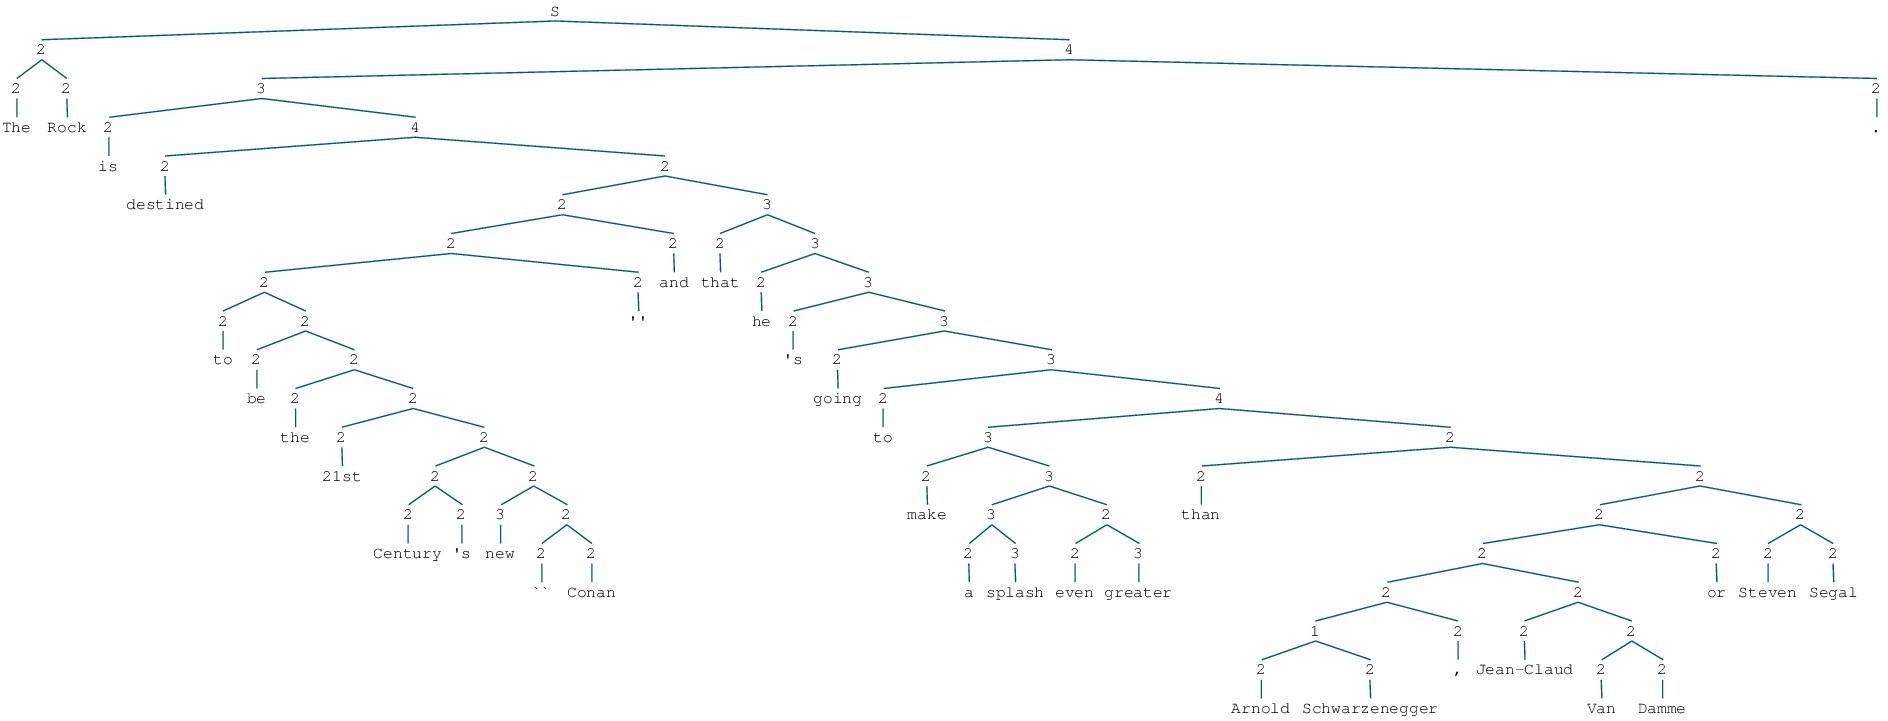

In [45]:
X_tree_train[0]

In [46]:
X_tree_dev, y_tree_dev = get_tree_dataset(sst.dev_reader)

### Pure NumPy TreeNN implementation

`TreeNN` is a pure NumPy implementation of this model. It should be regarded as a baseline for models of this form. The original SST paper includes evaluations of a wide range of models in this family.

In [47]:
tree_nn = TreeNN(
    sst_train_vocab, 
    embed_dim=100, 
    max_iter=100,
    eta=0.05) 

In [48]:
tree_nn.fit(X_tree_train, y_tree_train)

Finished epoch 100 of 100; error is 2.416002630512955

In [49]:
tree_dev_predictions = tree_nn.predict(X_tree_dev)

In [50]:
print(classification_report(y_tree_dev, tree_dev_predictions))

             precision    recall  f1-score   support

   negative       0.51      0.56      0.53       428
   positive       0.53      0.47      0.50       444

avg / total       0.52      0.52      0.52       872



In [51]:
tree_nn_glove = TreeNN(
    sst_glove_vocab,
    embedding=glove_embedding,
    embed_dim=None,  # Ignored when embedding is not `None`
    max_iter=100,
    eta=0.05) 

In [52]:
tree_nn_glove.fit(X_tree_train, y_tree_train)

Finished epoch 100 of 100; error is 1.337790645988493

In [53]:
tree_glove_dev_predictions = tree_nn_glove.predict(X_tree_dev)

In [54]:
print(classification_report(y_tree_dev, tree_glove_dev_predictions))

             precision    recall  f1-score   support

   negative       0.54      0.35      0.43       428
   positive       0.53      0.71      0.61       444

avg / total       0.54      0.54      0.52       872



## Exploratory exercises

These are largely meant to give you a feel for the material, but some of them could lead to projects and help you with future work for the course (especially the SST bake-off). These are not for credit.

1. In the [distributed representations as features](#Distributed-representations-as-features) section, we just summed  all of the leaf-node GloVe vectors to obtain a fixed-dimensional representation for all sentences. This ignores all of the tree structure. See if you can do better by paying attention to the binary tree structure: write a function `glove_subtree_phi` that obtains a vector representation for each subtree by combining the vectors of its daughters, with the leaf nodes again given by GloVe (any dimension you like) and the full representation of the sentence given by the final vector obtained by this recursive process. You can decide on how you combine the vectors. 

1. The default hidden activation function for `TfRNNClassifier` is `tf.nn.tanh`. This value is exposed via the `hidden_activation` keyword argument. See if you can get better results with [a different activation function](https://www.tensorflow.org/api_guides/python/nn). If you're feeling really ambitious, you could subclass `TfRNNClassifier` to define a new cost function (maybe with regularization) or optimizer. Deep learning offers a lot of design choices!

1. Most of the experiments above used random initial representations of the words. Try other initialization schemes by importing or rebuilding vectors from the VSM unit.

1. Tree-structured networks can be defined relatively easily in TensorFlow. [This excellent repository](https://github.com/erickrf/treernn) provides working code and a clear explanation. Get to know this code, and consider adapting it for use in SST experiments.

1. The final hidden state in the RNN Classifier is the basis for the classification decisions. It should also be a good embedding for the entire example. Is it? The function `sst.get_sentence_embedding_from_rnn` extracts this space from a trained model given a set of examples. Study this space to see what insights it can provide about what the model has learned.